# Parsing the trace files

In [402]:
import csv
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import json
import warnings
warnings.filterwarnings('ignore')

TIME_FMT = "%Y/%m/%d %H:%M"
TIME_FMT2 = "%Y-%m-%d %H:%M:%S"
BASETIME = pd.to_datetime("1970-01-01 00:00:00")

philly_trace = "philly/trace-data/cluster_job_log"
helios_base = "helios/data/"
alibaba_v2020_base = "alibaba/cluster-trace-gpu-v2020/data/"
alibaba_v2023_trace = "alibaba/cluster-trace-gpu-v2023/csv/openb_pod_list_default.csv"
acme_base = "acme/data/job_trace"
crux_trace = "crux/data/job.csv"

traces = {
    'philly 2019': None,
    'alibaba 2020': None,
    'helios 2021': None,
    'alibaba 2023': None,
    'acme 2024': None,
    'crux 2024': None
}

## Philly [ATC'19] trace

In [403]:
DATE_FORMAT_STR = '%Y-%m-%d %H:%M:%S'
MINUTES_PER_DAY = (24 * 60)
MICROSECONDS_PER_MINUTE = (60 * 1000)

def parse_date(date_str):
    """Parses a date string and returns a datetime object if possible.
    
       Args:
           date_str: A string representing a date.
        
       Returns:
           A datetime object if the input string could be successfully
           parsed, None otherwise.
    """
    if date_str is None or date_str == '' or date_str == 'None':
        return None
    return datetime.strptime(date_str, DATE_FORMAT_STR)

class Job:
    """Encapsulates a job."""
    
    def __init__(self, status, vc, jobid, attempts, submitted_time, user):
        """Records job parameters and computes key metrics.
        
           Stores the passed in arguments as well as the number of GPUs
           requested by the job. In addition, computes the queueing delay
           as defined as the delta between the submission time and the start
           time of the first attempt. Finally, computes run time as defined
           as the delta between the initial attempt's start time and the last
           attempt's finish time.
           
           NOTE: Some jobs do not have any recorded attempts, and some attempts
           have missing start and/or end times. A job's latest attempt having no
           end time indicates that the job was still running when the log data
           was collected.
   
           Args:
               status: One of 'Pass', 'Killed', 'Failed'.
               vc: The hash of the virtual cluster id the job was run in.
               jobid: The hash of the job id.
               attempts: A list of dicts, where each dict contains the following keys:
                   'start_time': The start time of the attempt.
                   'end_time': The end time of the attempt.
                   'detail': A list of nested dicts where each dict contains 
                             the following keys:
                        'ip': The server id.
                        'gpus': A list of the GPU ids allotted for this attempt.
                submitted_time: The time the job was submitted to the queue.
                user: The user's id.            
        """
        self._status = status
        self._vc = vc
        self._jobid = jobid
        for attempt in attempts:
            attempt['start_time'] = parse_date(attempt['start_time'])
            attempt['end_time'] = parse_date(attempt['end_time'])
        self._attempts = attempts
        self._submitted_time = parse_date(submitted_time)
        self._user = user
        
        if len(self._attempts) == 0:
            self._num_gpus = None
            self._run_time = None
            self._queueing_delay = None
        else:
            self._num_gpus = sum([len(detail['gpus']) for detail in self._attempts[0]['detail']])
            if self._attempts[0]['start_time'] is None:
                self._run_time = None
                self._queueing_delay = None
            else:
                if self._attempts[-1]['end_time'] is None:
                    self._run_time = None
                else:
                    self._run_time = (self._attempts[-1]['end_time'] -
                                      self._attempts[0]['start_time']).total_seconds()
                self._queueing_delay = (self._attempts[0]['start_time'] -
                                        self._submitted_time).total_seconds()
    
    @property
    def status(self):
        return self._status
    
    @property
    def vc(self):
        return self._vc
    
    @property
    def jobid(self):
        return self._jobid
    
    @property
    def attempts(self):
        return self._attempts
    
    @property
    def submitted_time(self):
        return self._submitted_time
    
    @property
    def user(self):
        return self._user
    
    @property
    def num_gpus(self):
        return self._num_gpus
    
    @property
    def queueing_delay(self):
        return self._queueing_delay
    
    @property
    def run_time(self):
        return self._run_time

with open(philly_trace, 'r') as f:
    cluster_job_log = json.load(f)

jobs = []
for i, j in enumerate(cluster_job_log):
    job = Job(**j)
    if not job.queueing_delay or not job.run_time:
        continue
    # job.run_time does not include queueing delay.
    jobs.append({'jobid': job.jobid, 'status': job.status,
                 'submitted_time': job.submitted_time,
                 'queueing': job.queueing_delay,
                 'running': job.run_time,
                 'jct': job.run_time + job.queueing_delay})
df = pd.DataFrame(jobs)
df['arrival_dt'] = pd.to_datetime(df['submitted_time'], format=TIME_FMT2)
df['arrival'] = (df['arrival_dt'] - df['arrival_dt'].min()).apply(lambda x: x.total_seconds())
traces['philly 2019'] = df.sort_values(by='arrival').reset_index(drop=True)
print(traces['philly 2019'].head(10))

                             jobid  status      submitted_time   queueing  \
0  application_1501012364013_16024  Killed 2017-08-14 23:27:00  1570682.0   
1  application_1501012364013_19938  Killed 2017-08-18 01:29:43  1304119.0   
2  application_1501012364013_19939  Killed 2017-08-18 01:29:44  1304118.0   
3  application_1501012364013_19940  Killed 2017-08-18 01:29:46  1304116.0   
4  application_1501012364013_20139  Killed 2017-08-18 07:46:45  1281497.0   
5  application_1501012364013_20168  Killed 2017-08-18 08:01:30  1280612.0   
6  application_1501012364013_20176  Killed 2017-08-18 08:31:36  1278806.0   
7  application_1501012364013_21310  Killed 2017-08-18 21:20:18  1232684.0   
8  application_1501012364013_21984  Killed 2017-08-21 05:21:52  1030990.0   
9  application_1501012364013_23793  Killed 2017-08-24 02:00:28   783874.0   

     running        jct          arrival_dt   arrival  
0  3613033.0  5183715.0 2017-08-14 23:27:00       0.0  
1  3222990.0  4527109.0 2017-08-18 01:29

## Helios [SC'21] trace

In [404]:
dfs = []
for name in ['Earth', 'Saturn', 'Uranus', 'Venus']:
    trace_name = helios_base + name + '/cluster_log.csv'
    df = pd.read_csv(trace_name)
    df['cluster_name'] = name
    df['arrival_dt'] = pd.to_datetime(df['submit_time'], format=TIME_FMT2)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
# Some jobs are incomplete and have NaN timestamps, ignore them.
df = df.drop(df[pd.isna(df['duration']) | \
                pd.isna(df['queue'])].index)
df['arrival'] = (df['arrival_dt'] - df['arrival_dt'].min()).apply(lambda x: x.total_seconds())
df['queueing'] = df['queue']
df['running'] = df['duration']
# Duration does not include queueing delay.
df['jct'] = df['duration'] + df['queueing']
# Filter out the non-positive duration. NB: queueing delay can be zero.
df = df.drop(df[(df['queueing'] < 0) | (df['jct'] <= 0)].index)

traces['helios 2021'] = df.sort_values(by='arrival').reset_index(drop=True)
print(traces['helios 2021'].head(10))

    job_id   user     vc  gpu_num  cpu_num  node_num      state  \
0   363167  u1Eem  vccJW       32      160         4    TIMEOUT   
1  2921826  uYlPU  vcSE7        1        1         1    TIMEOUT   
2  2922917  u9jR8  vcdoX        1        1         1    TIMEOUT   
3  2934117  uH3om  vcOIr        8        8         1    TIMEOUT   
4  2934215  uYlPU  vcSE7        1        1         1    TIMEOUT   
5  2934386  u90Bq  vcSE7        8        8         1    TIMEOUT   
6    76723  uMyhN  vcgkz        8        8         1  COMPLETED   
7  2940006  uyg4r  vcQ4H        8        8         1    TIMEOUT   
8  1380066  uVCWx  vcrV2        1        1         1    TIMEOUT   
9  1381347  ulqKP  vcG8f        8        1         1  CANCELLED   

           submit_time           start_time             end_time  duration  \
0  2020-03-18 04:01:39  2020-03-18 04:01:39  2020-04-01 04:01:54   1209615   
1  2020-03-18 14:21:22  2020-03-18 14:21:22  2020-04-01 14:21:45   1209623   
2  2020-03-18 17:31:00  2020

## Alibaba 2020 [NSDI'22] trace

In [405]:
dfj = pd.read_csv(alibaba_v2020_base + 'pai_job_table.csv', header=None, names=['job_name', 'inst_id', 'user', 'status', 'start_time', 'end_time'])
dft = pd.read_csv(alibaba_v2020_base + 'pai_task_table.csv', header=None, names=['job_name', 'task_name', 'inst_num', 'status', 'start_time',
                                                                                 'end_time', 'plan_cpu', 'plan_mem', 'plan_gpu', 'gpu_type'])
# Many tasks are under the same job name. Merge them into one record and keep the latest start/end times.
dft = dft.groupby('job_name').agg({'start_time': 'max', 'end_time': 'max'}).reset_index()
df = dfj.merge(dft, on=['job_name'], how='left', suffixes = ['','_task'])
df = df.dropna(subset=['start_time', 'end_time', 'start_time_task', 'end_time_task'])
df['arrival_dt'] = df['start_time'].apply(lambda x: pd.to_datetime(0) + relativedelta(seconds=x))
df['arrival'] = (df['arrival_dt'] - df['arrival_dt'].min()).apply(lambda x: x.total_seconds())
df['queueing'] = df['start_time_task'] - df ['start_time']
df['running'] = df['end_time'] - df['start_time_task']
df['jct'] = df['end_time'] - df ['start_time']
traces['alibaba 2020'] = df.drop(df[(df['queueing'] < 0) | (df['jct'] <= 0)].index).sort_values(by='arrival').reset_index(drop=True)
print(traces['alibaba 2020'].head(10))

                   job_name  \
0  193e6fdd5cb271f54d85f739   
1  231efd68de94779ed7b9aff6   
2  4d70a8930e415447fba17963   
3  96e053818c246cd68f301d40   
4  2883edbad23c6bef16f655c0   
5  895a99e58c36991c59509917   
6  b70720e730934ea003a83b42   
7  3e6f005d5fc08a0108f4eb1e   
8  7d90cacc27d735d9b3f024c2   
9  10e530eb422cec7bb19c6fd7   

                                             inst_id          user  \
0  b150d2eccab57c9539f8ba1c3804c37e5532e681dc7d0a...  74238accb90b   
1  e55465e9e26523cdeba168087a050aa950ac723bd7532e...  74238accb90b   
2  6f7d426945058a53111cc686c0fd5df2afb2ba017d0544...  74238accb90b   
3  5327aa4ce5fb0578f93779cab2b45bb6806c2b3d11ac3c...  74238accb90b   
4  8f26613dc5591cf8ab57f7abd4d37221bee5d3701443c1...  74238accb90b   
5  805b276d3a3328c425aca1f6633796411f1cd6df95e888...  74238accb90b   
6  4ef18d566fea077d8ebf1dcc9e04656601467d911560c5...  74238accb90b   
7  6cdf1f7137c6b942493ccce28221e6ef983311c96eaaf5...  74238accb90b   
8  478e9b8bf174778b7fe5815a5

## Alibaba 2023 [ATC'23] trace

In [406]:
df = pd.read_csv(alibaba_v2023_trace)
# Some jobs are incomplete and have NaN timestamps, ignore them.
df = df.drop(df[pd.isna(df['creation_time']) | \
                pd.isna(df['deletion_time']) | \
                pd.isna(df['scheduled_time'])].index)
df['arrival_dt'] = df['creation_time'].apply(lambda x: pd.to_datetime(0) + relativedelta(seconds=x))
df['arrival'] = (df['arrival_dt'] - df['arrival_dt'].min()).apply(lambda x: x.total_seconds())
# Diff the timestamps to get queueing and jct.
df['queueing'] = df['scheduled_time'] - df['creation_time']
df['running'] = df['deletion_time'] - df['scheduled_time']
df['jct'] = df['deletion_time'] - df['creation_time']
# Filter out the non-positive duration. NB: queueing delay can be zero.
traces['alibaba 2023'] = df.drop(df[(df['queueing'] < 0) | (df['jct'] <= 0)].index).sort_values(by='arrival').reset_index(drop=True)
print(traces['alibaba 2023'].head(10))

             name  cpu_milli  memory_mib  num_gpu  gpu_milli  gpu_spec qos  \
0  openb-pod-0000      12000       16384        1       1000       NaN  LS   
1  openb-pod-0001       6000       12288        1        460       NaN  LS   
2  openb-pod-0002      12000       24576        1       1000       NaN  LS   
3  openb-pod-0003       6000       12288        1        460       NaN  LS   
4  openb-pod-0004      12000       16384        1       1000       NaN  LS   
5  openb-pod-0005      20000       65536        0          0       NaN  LS   
6  openb-pod-0006       4000       16384        1       1000       NaN  LS   
7  openb-pod-0007      12000       16384        1       1000       NaN  LS   
8  openb-pod-0008      12000       16384        1       1000       NaN  LS   
9  openb-pod-0009      12000       16384        1       1000       NaN  LS   

  pod_phase  creation_time  deletion_time  scheduled_time          arrival_dt  \
0   Running              0       12537496             0.0 19

## Acme [NSDI'24] trace

In [407]:
dfs = []
for cluster in ['kalos', 'seren']:
    trace_name = f'{acme_base}/trace_{cluster}.csv'
    df = pd.read_csv(trace_name)
    if cluster == 'kalos':
        # Drop columns not in the seren trace so that they can be concatenated.
        df = df[df.columns.drop(list(df.filter(regex='mem_per_pod_GB') &
                                     df.filter(regex='shared_mem_per_pod') &
                                     df.filter(regex='fail_time') &
                                     df.filter(regex='stop_time')
                                    ))]
    df['cluster_name'] = cluster
    tmp = pd.to_datetime(df['submit_time'])
    df['arrival'] = (tmp - tmp.min()).apply(lambda x: x.total_seconds())
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
# Rebuild a uniform (fake) arrival time.
df['arrival_dt'] = df['arrival'].apply(lambda x: pd.to_datetime(0) + relativedelta(seconds=x))
df['queueing'] = df['queue']
df['running'] = df['duration']
# Duration does not include queueing delay.
df['jct'] = df['duration'] + df['queue']
# Filter out the non-positive duration. NB: queueing delay can be zero.
df = df.drop(df[(df['queueing'] < 0) | (df['jct'] <= 0)].index)
traces['acme 2024'] = df.sort_values(by='arrival').reset_index(drop=True)
print(traces['acme 2024'].head(10))

             job_id   user  node_num  gpu_num  cpu_num   type      state  \
0  dlctk696s0jbvitv  uf794         8       64      960  Other     FAILED   
1           5778432  u5907         1        8      128  Other     FAILED   
2           5778469  u5907         1        8      128  Other  COMPLETED   
3  dlcgiwd1g3i1cfgl  uf794         8       64      960  Other     FAILED   
4           5778565  u8742         1        8      128  Other     FAILED   
5  dlc1t2ypl09b8qtp  uf794         8       64      960  Other  CANCELLED   
6  dlcj0vimc1r8uc4f  uf794         8       64      960  Other  COMPLETED   
7           5778592  ud035         2       16      160  Other     FAILED   
8           5778612  ud035         4       32      320  Other  COMPLETED   
9  dlcyu9s048ourmoe  uf794         8       64      960  Other  COMPLETED   

                 submit_time                 start_time  \
0  2023-05-17 11:00:58+00:00  2023-05-17 11:01:08+00:00   
1  2023-03-01 00:18:22+08:00  2023-03-01 00:1

## Crux [SIGCOMM'24] trace

In [408]:
df = pd.read_csv(crux_trace)
# Filter out the irrelevant fields.
df = df[df.columns.drop(list(df.filter(regex='Unnamed') &
                             df.filter(regex='extended') &
                             df.filter(regex='etcd')
                            ))]
# Some jobs are incomplete and have NaN timestamps, ignore them.
df = df.drop(df[pd.isna(df['gmt_job_submitted']) | \
                pd.isna(df['gmt_job_running']) | \
                pd.isna(df['gmt_job_finished'])].index)
# Convert the string format timestamps to datetime objects.
df['gmt_job_submitted'] = pd.to_datetime(df['gmt_job_submitted'], format=TIME_FMT)
df['gmt_job_running'] = pd.to_datetime(df['gmt_job_running'], format=TIME_FMT)
df['gmt_job_finished'] = pd.to_datetime(df['gmt_job_finished'], format=TIME_FMT)
df['arrival_dt'] = df['gmt_job_submitted']
df['arrival'] = (df['gmt_job_submitted'] - df['gmt_job_submitted'].min()).apply(lambda x: x.total_seconds())
# Diff the timestamps to get queueing and jct.
df['queueing'] = (df['gmt_job_running'] - df['gmt_job_submitted']).apply(lambda x: x.total_seconds())
df['running'] = (df['gmt_job_finished'] - df['gmt_job_running']).apply(lambda x: x.total_seconds())
df['jct'] = (df['gmt_job_finished'] - df['gmt_job_submitted']).apply(lambda x: x.total_seconds())
# Filter out the non-positive duration. NB: queueing delay can be zero.
traces['crux 2024'] = df.drop(df[(df['queueing'] < 0) | (df['jct'] <= 0)].index).sort_values(by='arrival').reset_index(drop=True)
print(traces['crux 2024'].head(10))

      id                                                uid          job_name  \
0  10289  656dd28fa400e4b1a322fbf5996b6d7758212e46e62eca...  dlc1l3ajnoq4jyuw   
1  10290  b6d78abb565b72019a9c54b18a6e60d829efc5efd2ca40...  dlc10arh1gnnexe1   
2  10291  b2b5b26580369d3cd8e4a0704ec5c6178a849ad7ab7b70...  dlctd311gtqeax72   
3  10292  be8150f57c549c644317ea6a40326871d70070f05b0820...  dlcprb478l2ekj3h   
4  10293  c22785ec4f8a7ff3738cc7568e1097e876589a7d0125d6...  dlcqbbpj8g3txdux   
5  10295  a203d0cadc933266c555301063d9305fb6a60b002ac881...  dlc1bei96sdtujoa   
6  10296  9d4db3751fabaac04b132e5cb0f872e1e03fac9d307d4d...  dlc1v3pfd0c8wgui   
7  10297  28acca2a0cdedb622eb4a7bbea8b55bc72d23ecd85344c...  dlc1mg26cgbrtc0l   
8  10298  dcc8e1e77ce40c0d24dd5ceb967ef7bfb32c567e4591bf...  dlcc60mpwfezb94b   
9  10299  7f7882d9f71e9c7d8a18f4133a8a46575ba3abec15e2ec...  dlch5uq6cp3i3agz   

         kind                                          namespace      model  \
0  PyTorchJob  0235e5091b7cb4

# Utils

In [446]:
def trim_trace(df: pd.DataFrame, start: datetime, end: datetime) -> pd.DataFrame:
    """
    Trims a given trace df and only keeps jobs whose arrival time is between start and end.
    """
    if 'arrival_dt' not in df.columns:
        raise ValueError('df has no column named arrival_dt')

    trimmed = df[(df['arrival_dt'] >= start) & (df['arrival_dt'] <= end)]
    return trimmed

def trace_to_iat_dist(df: pd.DataFrame, output: str) -> pd.DataFrame:
    """
    Given a trace, convert it to an inter-arrival time (IAT) distribution.
    Also writes it to a csv file optionally.
    """
    # Drop all other columns.
    iat = df[['arrival']].diff().dropna().reset_index(drop=True)
    iat = iat['arrival'].value_counts(normalize=True).reset_index(drop=False)
    iat.columns = ['# IAT (sec)', 'prob (%)']
    iat['prob (%)'] *= 100
    if output:
        iat.to_csv(output, index=False)
    return iat

# Plots

## JCT/queueing distribution.

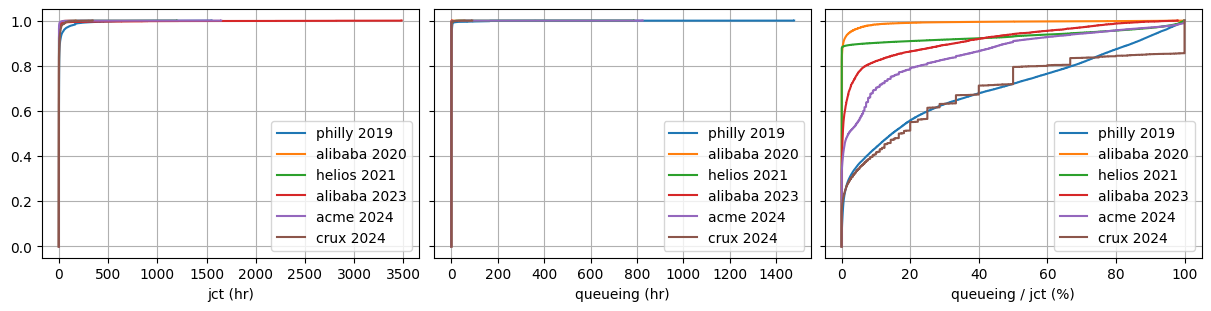

In [410]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3), layout="constrained", sharey=True)

for i, col in enumerate(['jct', 'queueing', 'ratio']):
    ax = axs[i]
    for name, trace in traces.items():
        if col == 'ratio':
            df = trace['queueing'] / trace['jct'] * 100
        else:
            df = trace[col] / 3600
        ax.ecdf(df, label=name)
    ax.ticklabel_format(style='plain', axis='x')
    label_str = 'queueing / jct (%)' if col == 'ratio' else f'{col} (hr)'
    ax.set_xlabel(label_str)
    ax.set_ylim([-0.05, 1.05])
    ax.legend()
    ax.grid()

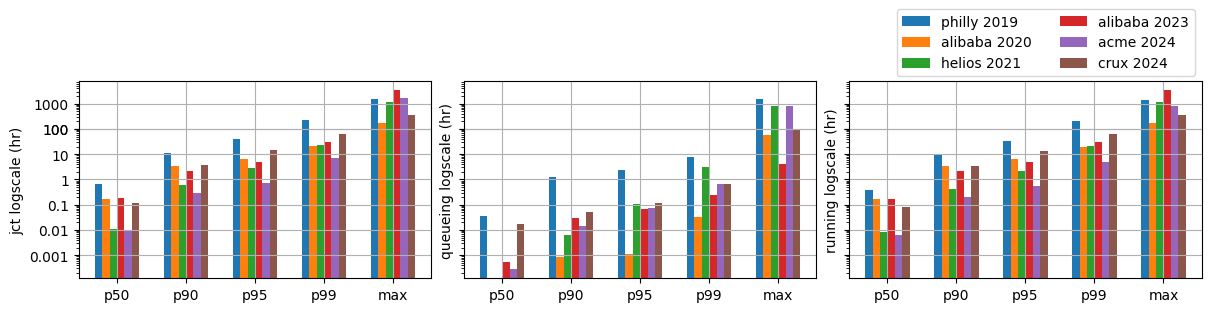

In [411]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3), layout="constrained", sharey=True)
labels = ['p50', 'p90', 'p95', 'p99', 'max']
width = 0.15
# X locations for the groups
x = np.arange(len(labels)) * 1.4

for i, col in enumerate(['jct', 'queueing', 'running']):
    ax = axs[i]
    for idx, (name, trace) in enumerate(traces.items()):
        df = trace[col] / 3600
        quantiles = [df.quantile(0.5), df.quantile(0.9), df.quantile(0.95), df.quantile(0.99), df.max()]
        # print(f'{name} {col}: {quantiles}')
        # Create side-by-side bar chart
        ax.bar(x + idx * width, quantiles, width=width, label=name)
    ax.set_xticks(x + 2.5 * width, labels)
    ax.set_ylabel(f'{col} logscale (hr)')
    ax.set_yscale('log')
    yticks = [.001, .01, .1, 1, 10, 100, 100, 1000]
    ax.set_yticks(yticks)
    ax.set_yticklabels(list(map(str, yticks)))
    ax.grid()
ax.legend(ncols=2, loc='upper right', bbox_to_anchor=(1, 1.4))

## inter-arrival time

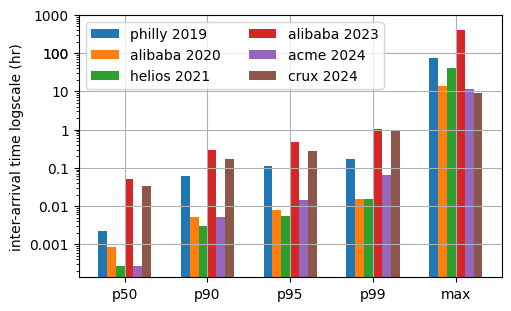

In [412]:
labels = ['p50', 'p90', 'p95', 'p99', 'max']
width = 0.15
# X locations for the groups
x = np.arange(len(labels)) * 1.4

fig, ax = plt.subplots(1, 1, figsize=(5, 3), layout="constrained")
for idx, (name, trace) in enumerate(traces.items()):
    df = trace.sort_values(by='arrival')
    diff = df['arrival'].diff().dropna() / 3600
    quantiles = [diff.quantile(0.5), diff.quantile(0.9), diff.quantile(0.95), diff.quantile(0.99), diff.max()]
    ax.bar(x + idx * width, quantiles, width=width, label=name)
ax.ticklabel_format(style='plain', axis='x')
ax.set_xticks(x + 2.5 * width, labels)
ax.set_ylabel('inter-arrival time logscale (hr)')
ax.set_yscale('log')
yticks = [.001, .01, .1, 1, 10, 100, 100, 1000]
ax.set_yticks(yticks)
ax.set_yticklabels(list(map(str, yticks)))
ax.grid()
ax.legend(ncols=2)

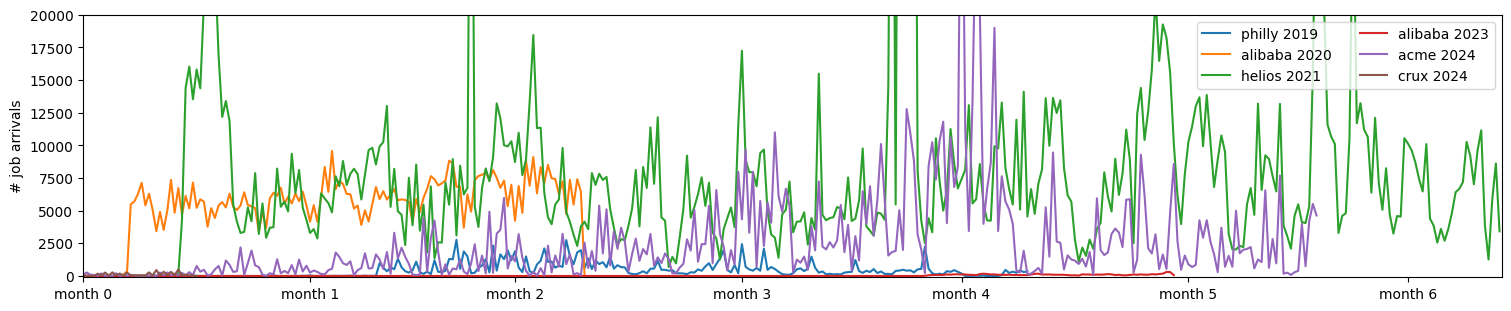

In [417]:
start = pd.to_datetime("1970-01-01 00:00:00")
end = pd.to_datetime("1970-07-13 19:00:00")

fig, ax = plt.subplots(1, 1, figsize=(15, 3), layout="constrained")
for idx, (name, trace) in enumerate(traces.items()):
    # arrival_dt is not aligned across traces, so use arrival for plotting.
    df = trace.sort_values(by='arrival')
    df['ts'] = pd.to_datetime(df['arrival'], unit='s')
    df.set_index('ts', inplace=True)
    # Aggregate window
    window_size = '12H'
    ts = df.resample(window_size).count()
    ax.plot(ts.index, ts['arrival'], label=name)
    # print(name, ts.index.min(), ts.index.max())
ax.set_xlim([start, end])
diff = relativedelta(end, start)
months = [start + relativedelta(months=i) for i in range(diff.years * 12 + diff.months + 1)]
ax.set_xticks(months)
ax.set_xticklabels([f'month {i}' for i in range(len(months))])
ax.set_ylim([-100, 20000])
ax.set_ylabel('# job arrivals')
ax.legend(ncols=2)

## Try to find your favorite bursty (or calm) duration in a trace, and convert that to an IAT distribution. 

    # IAT (sec)   prob (%)
0           0.0  89.541499
1           1.0   4.062073
2           3.0   1.908939
3           4.0   1.717651
4           2.0   1.314345
5           5.0   0.843131
6           6.0   0.293546
7           7.0   0.089031
8           8.0   0.050734
9           9.0   0.029019
10         10.0   0.022110
11         11.0   0.021715
12         13.0   0.013424
13         12.0   0.010660
14         16.0   0.010660
15         14.0   0.009870
16         15.0   0.008094
17         18.0   0.006909
18         17.0   0.005527
19         19.0   0.004935
20         21.0   0.004738
21         20.0   0.004540
22         23.0   0.003159
23         25.0   0.002961
24         24.0   0.002566
25         26.0   0.002369
26         22.0   0.002171
27         28.0   0.001777
28         36.0   0.001382
29         27.0   0.001184
30         33.0   0.000790
31         48.0   0.000790
32         30.0   0.000790
33         31.0   0.000592
34         50.0   0.000592
35         52.0   0.000592
3

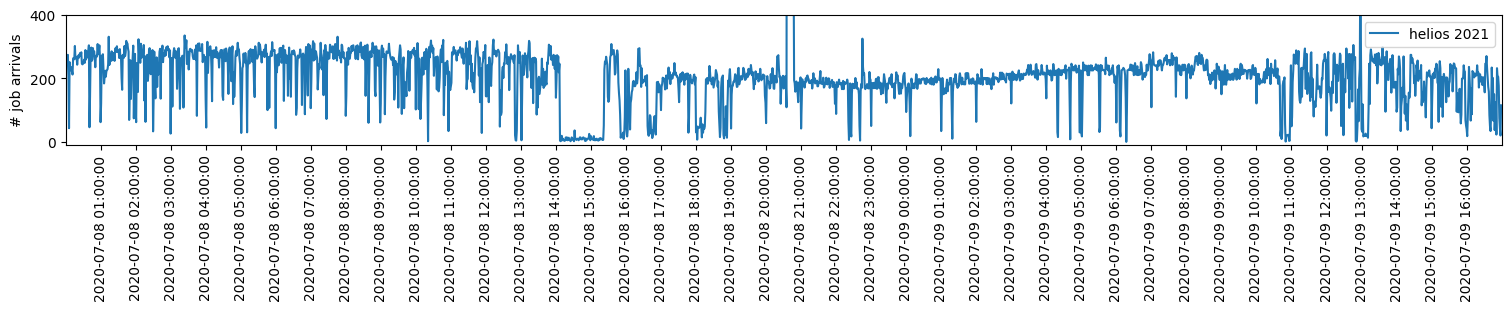

In [447]:
start = pd.to_datetime("2020-07-08 00:00:00")
end = pd.to_datetime("2020-07-09 17:00:00")

fig, ax = plt.subplots(1, 1, figsize=(15, 3), layout="constrained")
for idx, (name, trace) in enumerate(traces.items()):
    if name != 'helios 2021':
        continue
    df = trim_trace(trace, start, end)
    df.set_index('arrival_dt', inplace=True)
    # Aggregate window
    window_size = '60S'
    ts = df.resample(window_size).count()
    ax.plot(ts.index, ts['arrival'], label=name)
    # print(name, ts.index.min(), ts.index.max())
ax.set_xlim([start, end])
ticks = []
t = start
while t + relativedelta(hours=1) < end:
    t += relativedelta(hours=1)
    ticks.append(t)
ax.set_xticks(ticks)
ax.set_xticklabels(ticks, rotation=90)
ax.set_ylim([-10, 400])
ax.set_ylabel('# job arrivals')
ax.legend(ncols=2)

output = None
trimmed = trim_trace(traces['helios 2021'], pd.to_datetime("2020-07-08 00:00:00"), pd.to_datetime("2020-07-09 17:00:00"))
iat = trace_to_iat_dist(trimmed, output)
print(iat)